## Preliminaries

In [1]:
# Mount Drive

from google.colab import drive
drive.mount('/content/drive')

# Click the URL
# Sign in your google account
# Copy the code and paste in the box below
# Now you have access to all the files in your Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Other imports

import pandas as pd
# import ...

In [3]:
# folder to get and store data
data_path = "/content/drive/My Drive/COST Project/Colab notebooks/data/"
raw_data_path = "/content/drive/My Drive/COST Project/Colab notebooks/raw_data/"

## Input data

In [ ]:
data = pd.read_csv(raw_data_path+'equity_ibm_5y.csv', parse_dates=['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1260 non-null   datetime64[ns]
 1   High       1260 non-null   float64       
 2   Low        1260 non-null   float64       
 3   Open       1260 non-null   float64       
 4   Close      1260 non-null   float64       
 5   Volume     1260 non-null   float64       
 6   Adj Close  1260 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 69.0 KB


In [ ]:
data.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-06-01,171.039993,169.029999,170.210007,170.179993,2985500.0,136.927917
1,2015-06-02,170.449997,168.429993,169.660004,169.649994,2571400.0,136.501480
2,2015-06-03,171.559998,169.630005,170.500000,169.919998,2131000.0,136.718750
3,2015-06-04,170.600006,167.929993,169.529999,168.380005,3079300.0,135.479660
4,2015-06-05,168.910004,167.199997,168.250000,167.399994,3100500.0,134.691132


## split trainning data and evaluating data 

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
date_split = '2019-06-01'
train = data[:date_split]
test = data[date_split:]
train_data = []
for i in train.index:
  train_data.append(train["Adj Close"][i])

test_data = []
for i in test.index:
  test_data.append(test["Adj Close"][i])

In [ ]:
train

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-06-01,171.039993,169.029999,170.210007,170.179993,2985500.0,136.927917
2015-06-02,170.449997,168.429993,169.660004,169.649994,2571400.0,136.501480
2015-06-03,171.559998,169.630005,170.500000,169.919998,2131000.0,136.718750
2015-06-04,170.600006,167.929993,169.529999,168.380005,3079300.0,135.479660
2015-06-05,168.910004,167.199997,168.250000,167.399994,3100500.0,134.691132
...,...,...,...,...,...,...
2019-05-24,134.250000,131.589996,133.529999,132.279999,2596100.0,126.185776
2019-05-28,132.639999,130.270004,132.130005,130.460007,4908800.0,124.449631
2019-05-29,130.279999,128.320007,130.000000,129.690002,3679000.0,123.715096


In [ ]:
len(train_data), len(test_data)

(1008, 252)

## build agent

In [ ]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
import random
from collections import deque

class Agent:
	def __init__(self, state_size, is_eval=False, model_name=""):
		self.state_size = state_size # normalized previous days
		self.action_size = 3 # sit, buy, sell
		self.memory = deque(maxlen=2000)
		self.inventory = []
		self.model_name = model_name
		self.is_eval = is_eval

		self.gamma = 0.95
		self.epsilon = 1.0
		self.epsilon_min = 0.01
		self.epsilon_decay = 0.995

		self.model = load_model(model_name) if is_eval else self._model()

	def _model(self):
		model = Sequential()
		model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
		model.add(Dense(units=32, activation="relu"))
		model.add(Dense(units=32, activation="relu"))
		model.add(Dense(self.action_size, activation="linear"))
		model.compile(loss="mse", optimizer=Adam(lr=0.001))

		return model

	def act(self, state):
		if not self.is_eval and random.random() <= self.epsilon:
			return random.randrange(self.action_size)

		options = self.model.predict(state)
		return np.argmax(options[0])

	def expReplay(self, batch_size):
		mini_batch = []
		indices = np.random.randint(len(self.memory), size=batch_size)
		for i in indices:
			mini_batch.append(self.memory[i])

		for state, action, reward, next_state, done in mini_batch:
			target = reward
			if not done:
				target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

			target_f = self.model.predict(state)
			target_f[0][action] = target
			self.model.fit(state, target_f, epochs=1, verbose=0)

		if self.epsilon > self.epsilon_min:
			self.epsilon *= self.epsilon_decay 

## get states

In [ ]:
import numpy as np
import math
# prints formatted price
def formatPrice(n):
	return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# returns the sigmoid
def sigmoid(x):
	return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t
def getState(data, t, n):
	d = t - n + 1
	block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
	res = []
	for i in range(n - 1):
		res.append(sigmoid(block[i + 1] - block[i]))

	return np.array([res])

## train the model

In [ ]:

window_size = 30
agent = Agent(window_size)
l = len(train_data) - 1
batch_size = 20
episode_count = 10

for e in range(episode_count + 1):
	print("Episode " + str(e) + "/" + str(episode_count))
	state = getState(train_data, 0, window_size + 1)

	total_profit = 0
	agent.inventory = []

	for t in range(l):
		action = agent.act(state)

		# sit
		next_state = getState(train_data, t + 1, window_size + 1)
		reward = 0

		if action == 1: # buy
			agent.inventory.append(train_data[t])
			print("Buy: " + formatPrice(train_data[t]))
		
		elif action == 2 and len(agent.inventory) == 0: 
			reward = -1 
		elif action == 2 and len(agent.inventory) > 0: # sell
			bought_price = agent.inventory.pop(0)
			reward = max(train_data[t] - bought_price, 0)
			total_profit += train_data[t] - bought_price
			print("Sell: " + formatPrice(train_data[t]) + " | Profit: " + formatPrice(train_data[t] - bought_price))

		done = True if t == l - 1 else False
		agent.memory.append((state, action, reward, next_state, done))
		state = next_state

		if done:
			print("--------------------------------")
			print("Total Profit: " + formatPrice(total_profit))
			print("--------------------------------")

		if len(agent.memory) > batch_size:
			agent.expReplay(batch_size)

agent.model.save("final model")

Streaming output truncated to the last 5000 lines.
Buy: $122.39
Buy: $122.77
Sell: $122.77 | Profit: $6.83
Sell: $125.29 | Profit: $10.24
Sell: $126.17 | Profit: $10.02
Sell: $125.80 | Profit: $9.83
Sell: $124.09 | Profit: $6.32
Sell: $124.11 | Profit: $1.15
Sell: $122.64 | Profit: $0.12
Buy: $125.05
Buy: $125.51
Buy: $126.18
Buy: $119.13
Buy: $120.87
Sell: $123.51 | Profit: $3.23
Sell: $124.48 | Profit: $2.08
Sell: $121.67 | Profit: -$1.10
Sell: $123.02 | Profit: -$2.03
Sell: $124.25 | Profit: -$1.27
Sell: $126.46 | Profit: $0.28
Buy: $122.21
Sell: $125.06 | Profit: $5.94
Sell: $127.91 | Profit: $7.04
Sell: $128.55 | Profit: $6.33
Buy: $129.64
Sell: $129.30 | Profit: -$0.35
Buy: $129.37
Buy: $128.49
Buy: $127.57
Buy: $127.38
Buy: $127.06
Buy: $127.38
Sell: $128.17 | Profit: -$1.21
Sell: $129.53 | Profit: $1.05
Sell: $129.90 | Profit: $2.34
Sell: $128.95 | Profit: $1.57
Sell: $131.00 | Profit: $3.94
Buy: $123.61
Sell: $125.19 | Profit: -$2.19
Sell: $127.99 | Profit: $4.38
Buy: $134.57


## evaluate the model


In [ ]:
window_size = 30
agent = Agent(window_size, True, "final model")
l = len(test_data) - 1
batch_size = 20

state = getState(test_data, 0, window_size + 1)
total_profit = 0
agent.inventory = []
action_list = []
profit_list = []
for t in range(l):
	action = agent.act(state)

	# sit
	next_state = getState(test_data, t + 1, window_size + 1)
	reward = 0

	if action == 1: # buy
		agent.inventory.append(test_data[t])
		print("Buy: " + formatPrice(test_data[t]))

	elif action == 2 and len(agent.inventory) > 0: # sell
		bought_price = agent.inventory.pop(0)
		reward = max(test_data[t] - bought_price, 0)
		total_profit += test_data[t] - bought_price
		print("Sell: " + formatPrice(test_data[t]) + " | Profit: " + formatPrice(test_data[t] - bought_price))

	done = True if t == l - 1 else False
	agent.memory.append((state, action, reward, next_state, done))
	state = next_state
	action_list.append(action)
	profit_list.append(total_profit)
	
	if done:
		print("--------------------------------")
		print(" Total Profit: " + formatPrice(total_profit))
		print("--------------------------------")

Buy: $126.13
Sell: $127.17 | Profit: $1.04
Buy: $128.92
Buy: $128.73
Sell: $130.10 | Profit: $1.17
Sell: $130.76 | Profit: $2.03
Buy: $132.14
Buy: $132.14
Sell: $131.55 | Profit: -$0.59
Sell: $133.44 | Profit: $1.30
Buy: $133.76
Buy: $135.02
Buy: $134.87
Sell: $132.91 | Profit: -$0.85
Sell: $134.00 | Profit: -$1.02
Sell: $134.73 | Profit: -$0.13
Buy: $143.46
Sell: $144.39 | Profit: $0.93
Buy: $143.39
Sell: $140.47 | Profit: -$2.93
Buy: $135.22
Sell: $126.68 | Profit: -$8.54
Buy: $125.46
Buy: $126.60
Buy: $128.14
Sell: $130.18 | Profit: $4.72
Sell: $129.43 | Profit: $2.83
Sell: $131.57 | Profit: $3.44
Buy: $137.99
Sell: $136.94 | Profit: -$1.05
Buy: $137.12
Buy: $136.75
Sell: $138.17 | Profit: $1.05
Sell: $138.55 | Profit: $1.80
Buy: $137.79
Sell: $137.09 | Profit: -$0.69
Buy: $130.72
Sell: $131.23 | Profit: $0.51
Buy: $130.54
Buy: $129.07
Buy: $130.81
Sell: $132.87 | Profit: $2.34
Sell: $133.09 | Profit: $4.02
Sell: $133.95 | Profit: $3.14
Buy: $134.46
Buy: $134.39
Sell: $132.41 | Prof

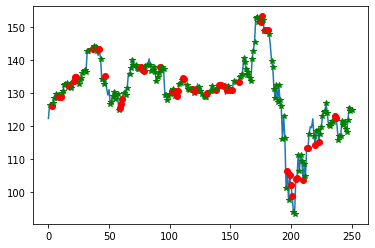

In [ ]:
import matplotlib.pyplot as plt
plt.plot(test_data)
for i in range(len(action_list)):
  if action_list[i] == 1: # buy 
    plt.plot(i,test_data[i], 'ro')
  elif action_list[i] == 2: # sell
    plt.plot(i,test_data[i], 'g*')

In [ ]:
len(test_data)

251

### Trying a different method

In [ ]:
pip install gym-anytrading

     |████████████████████████████████| 174kB 8.4MB/s 


In [ ]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
import pandas as pd
from enum import Enum
import matplotlib.pyplot as plt

We first define actions and positions

In [ ]:
class Actions(Enum):
    Sell = 0
    Buy = 1


class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long


class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, df, window_size):
        assert df.ndim == 2

        self.seed()
        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = spaces.Discrete(len(Actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float32)

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None


    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def reset(self):
        self._done = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Short
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 1.  # unit
        self._first_rendering = True
        return self._get_observation()


    def step(self, action):
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._update_profit(action)

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade:
            self._position = self._position.opposite()
            self._last_trade_tick = self._current_tick

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        return observation, step_reward, self._done, info


    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size):self._current_tick]


    def render(self, mode='human'):

        def _plot_position(position, tick):
            color = None
            if position == Positions.Short:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

        plt.pause(0.01)


    def render_all(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.plot(long_ticks, self.prices[long_ticks], 'go')

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )


    def save_rendering(self, filepath):
        plt.savefig(filepath)


    def pause_rendering(self):
        plt.show()


    def _process_data(self):
        raise NotImplementedError


    def _calculate_reward(self, action):
        raise NotImplementedError


    def _update_profit(self, action):
        raise NotImplementedError


    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError

In [ ]:
import gym
import gym_anytrading

env = gym.make('stocks-v0')

In [ ]:
custom_env = gym.make('stocks-v0',
               df = train,
               window_size = 10,
               frame_bound = (10, 300))

In [ ]:
print("env information:")
print("> shape:", env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", env.prices.shape)
print("> signal_features.shape:", env.signal_features.shape)
print("> max_possible_profit:", env.max_possible_profit())

print()
print("custom_env information:")
print("> shape:", custom_env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", custom_env.prices.shape)
print("> signal_features.shape:", custom_env.signal_features.shape)
print("> max_possible_profit:", custom_env.max_possible_profit())

env information:
> shape: (30, 2)
> df.shape: (2335, 6)
> prices.shape: (2335,)
> signal_features.shape: (2335, 2)
> max_possible_profit: 324533.2390176079

custom_env information:
> shape: (10, 2)
> df.shape: (2335, 6)
> prices.shape: (300,)
> signal_features.shape: (300, 2)
> max_possible_profit: 4.418324332536319


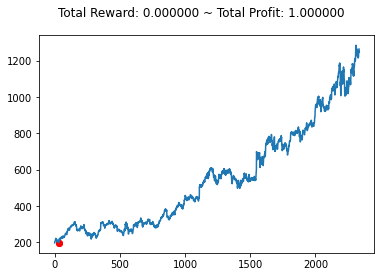

In [ ]:
env.reset()
env.render()

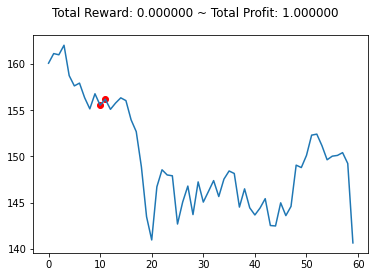

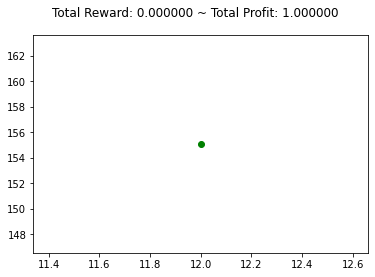

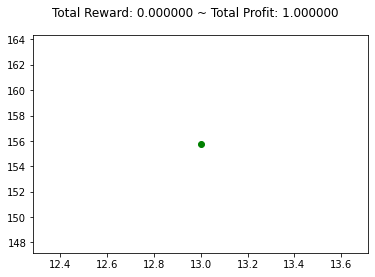

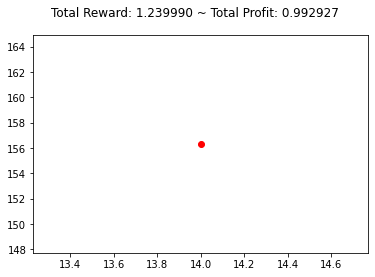

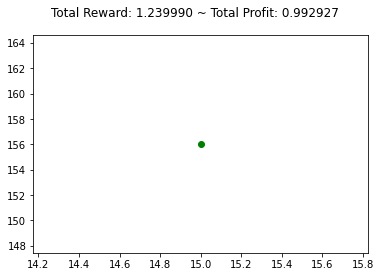

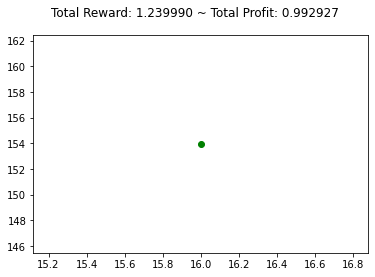

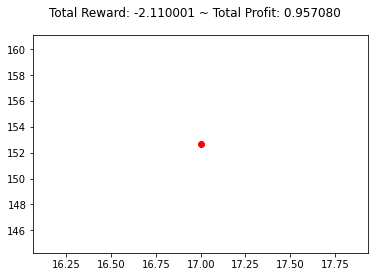

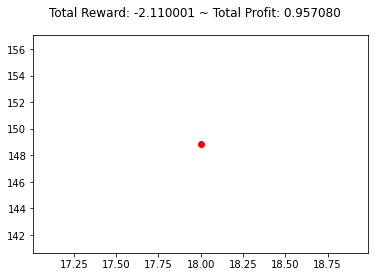

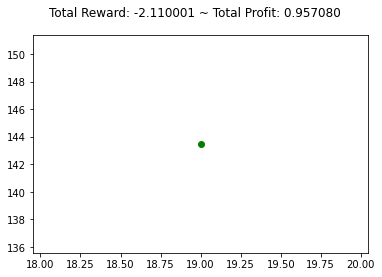

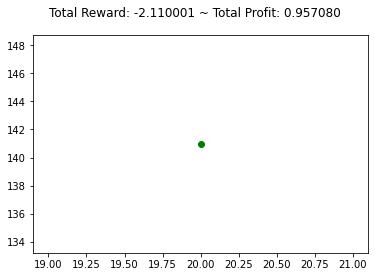

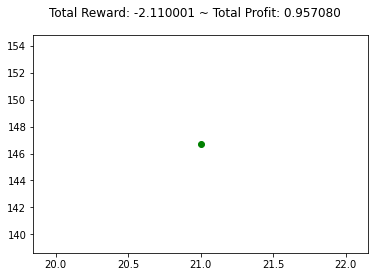

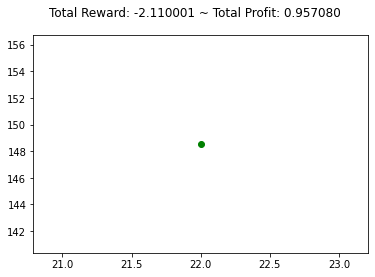

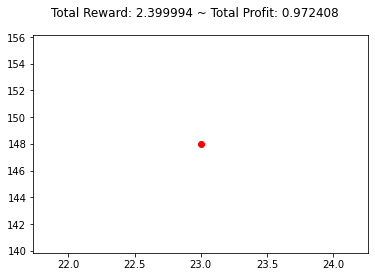

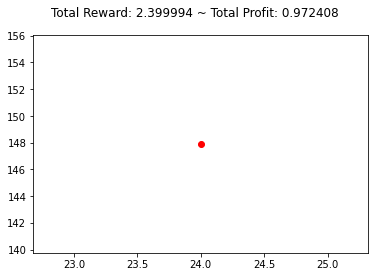

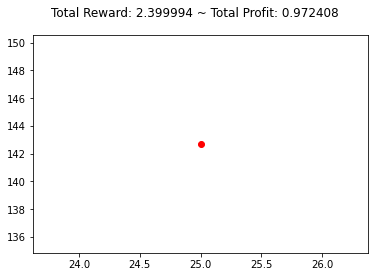

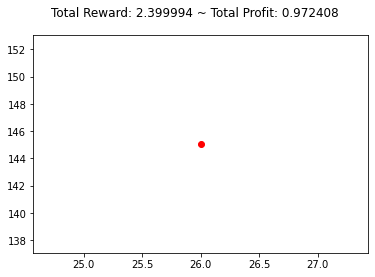

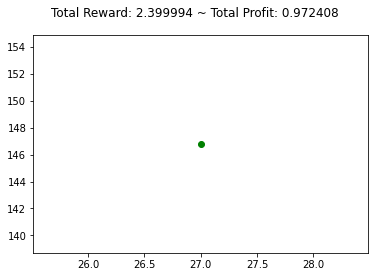

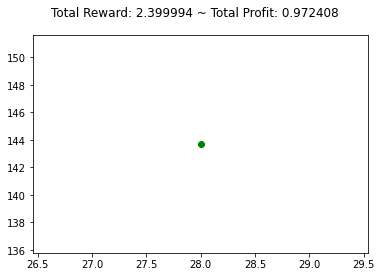

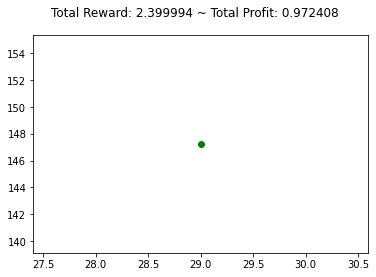

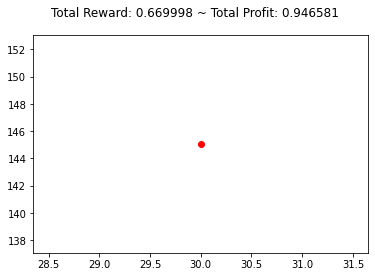

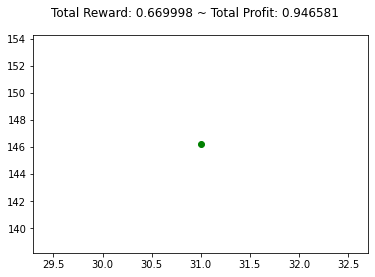

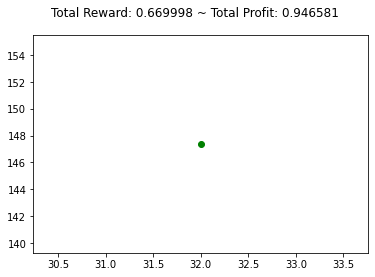

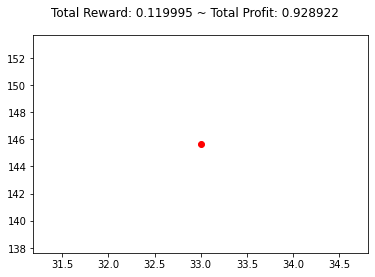

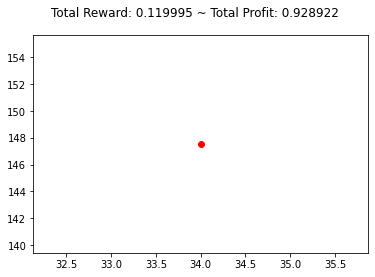

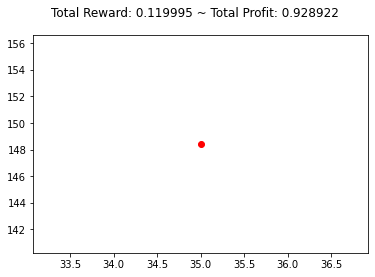

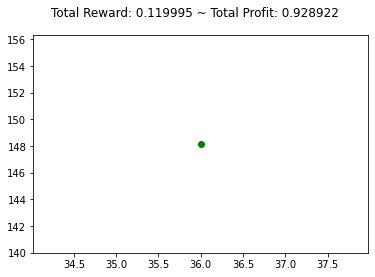

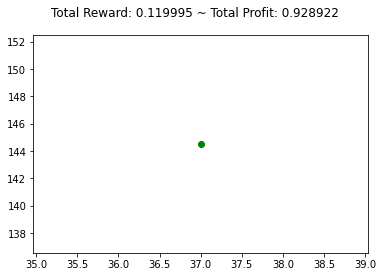

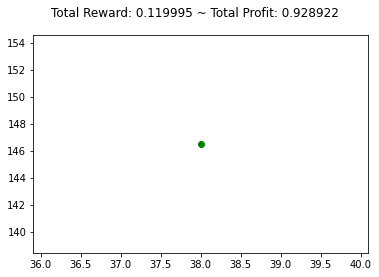

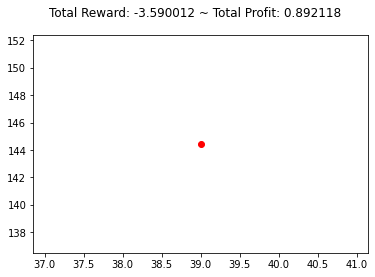

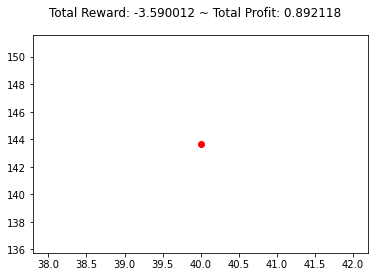

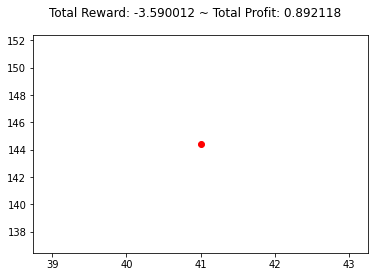

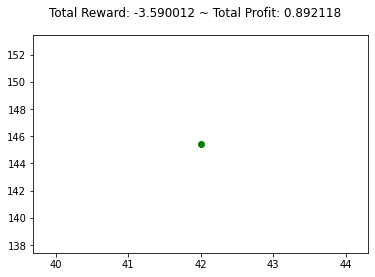

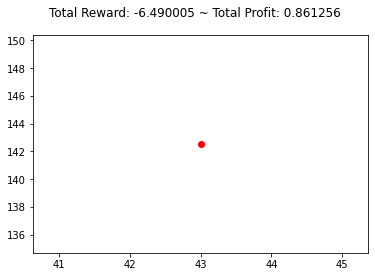

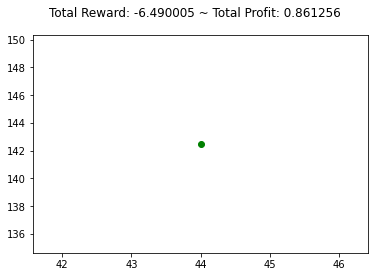

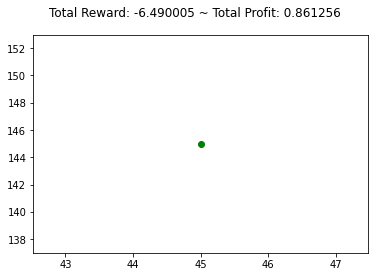

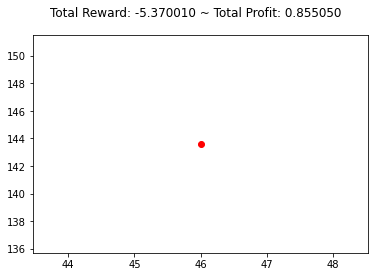

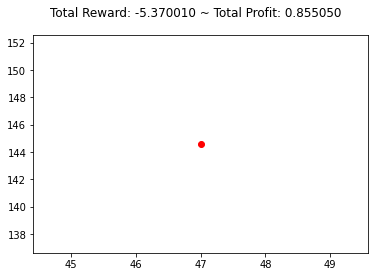

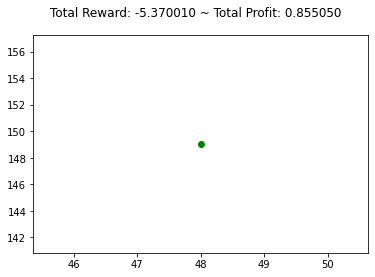

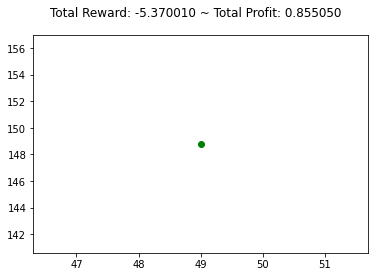

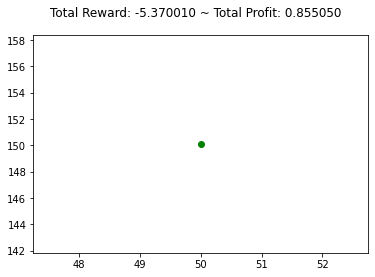

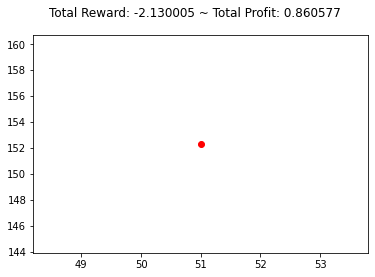

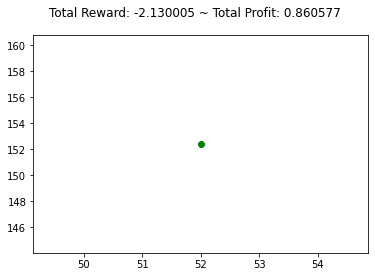

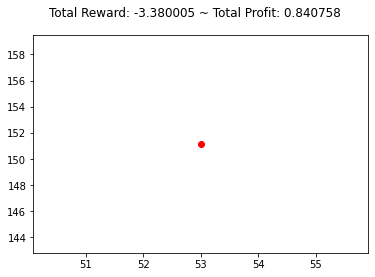

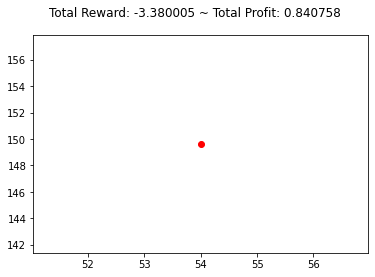

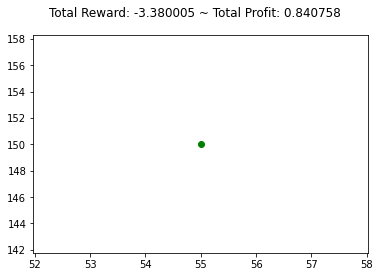

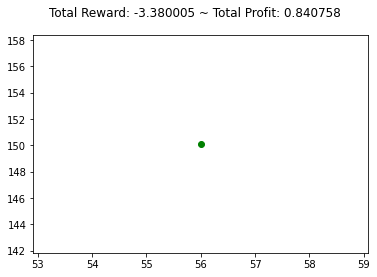

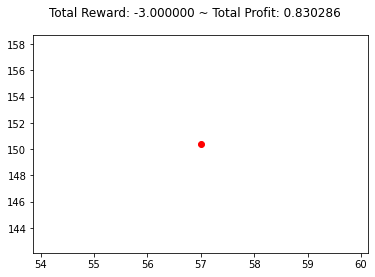

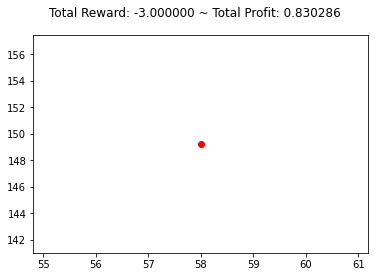

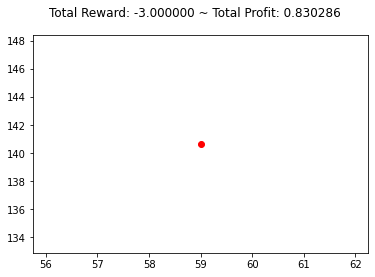

info: {'total_reward': -3.0, 'total_profit': 0.830286459269806, 'position': 0}


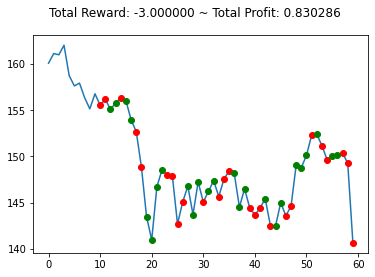

In [ ]:
import gym
import gym_anytrading
import matplotlib.pyplot as plt

env = gym.make('stocks-v0', df=data,frame_bound=(50, 100), window_size=10)

observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.render_all()
plt.show()

In [ ]:
import numpy as np

class StocksEnv(TradingEnv):

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2

        self.frame_bound = frame_bound
        super().__init__(df, window_size)

        self.trade_fee_bid_percent = 0.01  # unit
        self.trade_fee_ask_percent = 0.005  # unit


    def _process_data(self):
        prices = self.df.loc[:, 'Close'].to_numpy()

        prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
        prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]

        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff))

        return prices, signal_features


    def _calculate_reward(self, action):
        step_reward = 0

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price

            if self._position == Positions.Long:
                step_reward += price_diff

        return step_reward


    def _update_profit(self, action):
        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade or self._done:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self._position == Positions.Long:
                shares = (self._total_profit * (1 - self.trade_fee_ask_percent)) / last_trade_price
                self._total_profit = (shares * (1 - self.trade_fee_bid_percent)) * current_price


    def max_possible_profit(self):
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Short
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Long

            if position == Positions.Long:
                current_price = self.prices[current_tick - 1]
                last_trade_price = self.prices[last_trade_tick]
                shares = profit / last_trade_price
                profit = shares * current_price
            last_trade_tick = current_tick - 1

        return profit

In [ ]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size
    end = frame_bound[1]
    prices = df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = df.loc[:, ['Close', 'Open', 'High', 'Low']].to_numpy()[start:end]
    return prices, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, prices, signal_features, **kwargs):
        self._prices = prices
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._prices, self._signal_features

    
prices, signal_features = my_process_data(df=data, window_size=30, frame_bound=(30, len(data)))
env = MyStocksEnv(prices, signal_features, df=data, window_size=30, frame_bound=(30, len(data)))

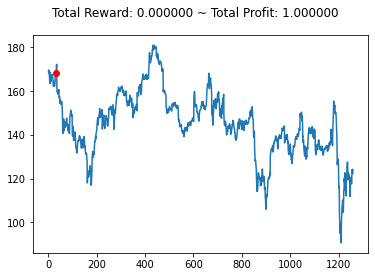

In [ ]:
env.reset()
env.render_all()

info: {'total_reward': -4.909965515136662, 'total_profit': 0.009692245608476079, 'position': 0}


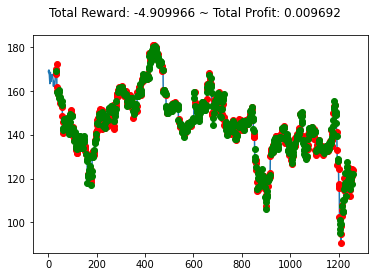

In [ ]:
observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.render_all()
plt.show()

# Method 3

In [4]:
#!pip install stockstats

In [5]:
#import
from __future__ import absolute_import
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
from stockstats import StockDataFrame as Sdf
from sklearn import preprocessing

Environment




In [6]:
class Env(object):
    """Abstract class for an environment. Simplified OpenAI API.
    """

    def __init__(self):
        self.n_actions = None
        self.state_shape = None

    def step(self, action):
        """Run one timestep of the environment's dynamics.
        Accepts an action and returns a tuple (observation, reward, done, info).
        Args:
            action (numpy.array): action array
        Returns:
            tuple:
                - observation (numpy.array): Agent's observation of the current environment.
                - reward (float) : Amount of reward returned after previous action.
                - done (bool): Whether the episode has ended, in which case further step() calls will return undefined results.
                - info (str): Contains auxiliary diagnostic information (helpful for debugging, and sometimes learning).
        """
        raise NotImplementedError()

    def reset(self):
        """Reset the state of the environment and returns an initial observation.
        Returns:
            numpy.array: The initial observation of the space. Initial reward is assumed to be 0.
        """
        raise NotImplementedError()

    def render(self):
        """Render the environment.
        """
        raise NotImplementedError()


class DataGenerator(object):
    """Parent class for a data generator. Do not use directly.
    Overwrite the _generator method to create a custom data generator.
    """

    def __init__(self, **gen_kwargs):
        """Initialisation function. The API (gen_kwargs) should be defined in
        the function _generator.
        """
        self._trainable = False
        self.gen_kwargs = gen_kwargs
        # We pass self explicitely since we sometimes override rewind (see csv generator)
        DataGenerator.rewind(self)
        self.n_products = len(next(self)) / 2
        DataGenerator.rewind(self)

    @staticmethod
    def _generator(**kwargs):
        """Generator function. The keywords arguments entirely defines the API
        of the class. This must have a yield statement.
        """
        raise NotImplementedError()

    def __next__(self):
        """Return the next element in the generator.
        Args:
            numpy.array: next row of the generator
        """
        try:
            return next(self.generator)
        except StopIteration as e:
            self._iterator_end()
            raise(e)

    def rewind(self):
        """Rewind the generator.
        """
        self.generator = self._generator(**self.gen_kwargs)

    def _iterator_end(self):
        """End of iterator logic.
        """
        pass

In [7]:

# np.random.seed(0)

plt.style.use('dark_background')
mpl.rcParams.update(
    {
        "font.size": 15,
        "axes.labelsize": 15,
        "lines.linewidth": 1,
        "lines.markersize": 8
    }
)
logging.basicConfig(filename='double_duelling.log', level=logging.INFO)
# create logger
logger = logging.getLogger('tx')
logger.setLevel(logging.INFO)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)

# create formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)
logger.propagate = False
logger.setLevel(logging.WARNING) # saeed: not to print the logg in console

class Indicator_1(Env):
    """Class for a discrete (buy/hold/sell) spread trading environment.
    """

    _actions = {
        'hold': np.array([1, 0, 0]),
        'buy': np.array([0, 1, 0]),
        'sell': np.array([0, 0, 1])
    }

    _positions = {
        'flat': np.array([1, 0, 0]),
        'long': np.array([0, 1, 0]),
        'short': np.array([0, 0, 1])
    }

    def __init__(self, data_generator, episode_length=1000,
                 trading_fee=0, time_fee=0, profit_taken=20, stop_loss=-10,
                 reward_factor=10000, history_length=2):
        """Initialisation function
        Args:
            data_generator (tgym.core.DataGenerator): A data
                generator object yielding a 1D array of bid-ask prices.
            episode_length (int): number of steps to play the game for
            trading_fee (float): penalty for trading
            time_fee (float): time fee
            history_length (int): number of historical states to stack in the
                observation vector.
        """

        assert history_length > 0
        self._data_generator = data_generator
        self._first_render = True
        self._trading_fee = trading_fee
        self._time_fee = time_fee
        self._episode_length = episode_length
        self.n_actions = 3
        self._prices_history = []
        self._history_length = history_length
        self._tick_buy = 0
        self._tick_sell = 0
        self.tick_mid = 0 # saeed
        self.tick_cci_14 = 0
        self.tick_rsi_14=0
        self.tick_dx_14 = 0
        self._price = 0
        self._round_digits = 4
        self._holding_position = []  # [('buy',price, profit_taken, stop_loss),...]
        self._max_lost = -1000
        self._reward_factor = reward_factor
        self.reset()
        self.TP_render=False
        self.SL_render = False
        self.Buy_render=False
        self.Sell_render=False
        self.current_action="-"
        self.current_reward=0
        self.unr_pnl=0

    def reset(self):
        """Reset the trading environment. Reset rewards, data generator...
        Returns:
            observation (numpy.array): observation of the state
        """
        self._iteration = 0
        self._data_generator.rewind()
        # self._data_generator._iterator_end()
        self._total_reward = 0
        self._total_pnl = 0
        self._current_pnl = 0
        self._position = self._positions['flat']
        # self._entry_price = 0
        # self._exit_price = 0
        self._closed_plot = False
        self._holding_position = []
        self._max_lost = -1000
        for i in range(self._history_length):
            self._prices_history.append(next(self._data_generator))
        self._tick_buy, self._tick_sell,self.tick_mid ,self.tick_rsi_14,self.tick_cci_14= \
            self._prices_history[0][:5]
        # self._tick_buy, self._tick_sell,self.tick_mid ,self.tick_rsi_14,self.tick_cci_14, self.tick_dx_14= \
        #     self._prices_history[0][:6]

        observation = self._get_observation()
        self.state_shape = observation.shape
        self._action = self._actions['hold']
        return observation

    def step(self, action):
        """Take an action (buy/sell/hold) and computes the immediate reward.
        Args:
            action (numpy.array): Action to be taken, one-hot encoded.
        Returns:
            tuple:
                - observation (numpy.array): Agent's observation of the current environment.
                - reward (float) : Amount of reward returned after previous action.
                - done (bool): Whether the episode has ended, in which case further step() calls will return undefined results.
                - info (dict): Contains auxiliary diagnostic information (helpful for debugging, and sometimes learning).
        """

        self._action = action
        self._iteration += 1
        done = False
        info = {}
        if all(self._position != self._positions['flat']):
            reward = -self._time_fee
        self._current_pnl=0

        #-------------------
        instant_pnl=0
        reward = -self._time_fee
        if all(action == self._actions['buy']):
            reward -= self._trading_fee
            if all(self._position == self._positions['flat']):
                self._position = self._positions['long']
                self._entry_price = self._price = self._tick_buy
                self.Buy_render = True
            elif all(self._position == self._positions['short']):
                self._exit_price = self._exit_price = self._tick_sell
                instant_pnl = self._entry_price - self._exit_price
                self._position = self._positions['flat']
                self._entry_price = 0
                # self.Buy_render = True
                if (instant_pnl > 0):
                    self.TP_render=True
                else:
                    self.SL_render=True

        elif all(action == self._actions['sell']):
            reward -= self._trading_fee
            if all(self._position == self._positions['flat']):
                self._position = self._positions['short']
                self._entry_price = self._price = self._tick_sell
                self.Sell_render = True
            elif all(self._position == self._positions['long']):
                self._exit_price = self._tick_buy
                instant_pnl = self._exit_price - self._entry_price
                self._position = self._positions['flat']
                self._entry_price = 0
                # self.Sell_render = True
                if (instant_pnl > 0):
                    self.TP_render = True
                else:
                    self.SL_render = True

        else:
            self.Buy_render = self.Sell_render = False
            self.TP_render = self.SL_render = False

        reward += instant_pnl
        self._total_pnl += instant_pnl
        self._total_reward += reward

        try:
            self._prices_history.append(next(self._data_generator))
            self._tick_sell, self._tick_buy, self.tick_mid, self.tick_rsi_14, self.tick_cci_14= \
            self._prices_history[-1][:5]
        except StopIteration:
            done = True
            info['status'] = 'No more data.'

        # Game over logic
        if self._iteration >= self._episode_length:
            done = True
            info['status'] = 'Time out.'
        if reward <= self._max_lost:
            done = True
            info['status'] = 'Bankrupted.'
        if self._closed_plot:
            info['status'] = 'Closed plot'

        observation = self._get_observation()

        return observation, reward, done, info

    def _handle_close(self, evt):
        self._closed_plot = True


    def return_calc(self,render_show=False):
        trade_details= {}
        if self.Sell_render:
            trade_details = {'Trade':'SELL','Price':self._tick_sell,'Time':self._iteration}
        elif self.Buy_render:
            trade_details = {'Trade': 'BUY', 'Price': self._tick_buy, 'Time': self._iteration}
        if self.TP_render:
            trade_details = {'Trade': 'TP', 'Price': self._exit_price, 'Time': self._iteration}
        elif self.SL_render:
            trade_details = {'Trade': 'SL', 'Price': self._exit_price, 'Time': self._iteration}

        if(not render_show):
            self.TP_render=self.SL_render=False
            self.Buy_render=self.Sell_render=False

        return trade_details

    def render(self, savefig=False, filename='myfig'):
        """Matlplotlib rendering of each step.
        Args:
            savefig (bool): Whether to save the figure as an image or not.
            filename (str): Name of the image file.
        """
        if self._first_render:
            self._f, (self._ax, self._ay, self._az, self._at) = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=False, squeeze=True,
                        gridspec_kw={'height_ratios': [4, 1, 1, 0]},)



            self._ax = [self._ax]
            self._ay = [self._ay]
            self._az = [self._az]
            self._at = [self._at]
            self._f.set_size_inches(12, 6)
            self._first_render = False
            self._f.canvas.mpl_connect('close_event', self._handle_close)


        #  price
        ask, bid, mid, rsi, cci = self._tick_buy, self._tick_sell,self.tick_mid, self.tick_rsi_14, self.tick_cci_14

        self._ax[-1].plot([self._iteration, self._iteration + 1], [mid, mid], color='white')
        self._ay[-1].plot([self._iteration, self._iteration + 1], [cci, cci], color='green')
        self._az[-1].plot([self._iteration, self._iteration + 1], [rsi, rsi], color='blue')
        self._ay[0].set_ylabel('CCI')
        self._az[0].set_ylabel('RSI')

        ymin, ymax = self._ax[-1].get_ylim()
        yrange = ymax - ymin
        if self.Sell_render:
            self._ax[-1].scatter(self._iteration + 0.5, bid + 0.03 *
                                 yrange, color='orangered', marker='v')
        elif self.Buy_render:
            self._ax[-1].scatter(self._iteration + 0.5, ask - 0.03 *
                                 yrange, color='lawngreen', marker='^')
        if self.TP_render:
            self._ax[-1].scatter(self._iteration + 0.5, bid + 0.03 *
                                 yrange, color='gold', marker='.')
        elif self.SL_render:
            self._ax[-1].scatter(self._iteration + 0.5, ask - 0.03 *
                                 yrange, color='maroon', marker='.')


        self.TP_render=self.SL_render=False
        self.Buy_render=self.Sell_render=False

        plt.suptitle('Total Reward: ' + "%.2f" % self._total_reward +
                     '  Total PnL: ' + "%.2f" % self._total_pnl +
                     '  Unrealized Return: ' + "%.2f" % (self.unrl_pnl*100)  + "% "+
                     '  Pstn: ' + ['flat', 'long', 'short'][list(self._position).index(1)] +
                     '  Action: ' + ['flat', 'long', 'short'][list(self._action).index(1)] +
                     '  Tick:' + "%.2f" % self._iteration)
        self._f.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

        plt.xticks(range(self._iteration)[::5])
        plt.xlim([max(0, self._iteration - 80.5), self._iteration + 0.5])

        plt.subplots_adjust(top=0.85)
        plt.pause(0.00001) # 0.01
        if savefig:
            plt.savefig(filename)

    def _get_observation(self):
        """Concatenate all necessary elements to create the observation.
        Returns:
            numpy.array: observation array.
        """
        if all(self._position==self._positions['flat']):
            self.unrl_pnl=0
        elif all(self._position==self._positions['long']):
            self.unrl_pnl = (self._prices_history[-1][2]-self._price)/self._prices_history[-1][2]
        elif all(self._position==self._positions['short']):
            self.unrl_pnl = (self._price - self._prices_history[-1][2])/self._prices_history[-1][2]

        return np.concatenate(
            [self._prices_history[-1][3:]] +
            [
                np.array([self.unrl_pnl]),
                np.array(self._position)
            ]
        )

    @staticmethod
    def random_action_fun():
        """The default random action for exploration.
        We hold 80% of the time and buy or sell 10% of the time each.
        Returns:
            numpy.array: array with a 1 on the action index, 0 elsewhere.
        """
        return np.random.multinomial(1, [0.8, 0.1, 0.1])

In [8]:


class TAStreamer(DataGenerator):
    """Data generator from csv file.
    The csv file should no index columns.
    Args:
        filename (str): Filepath to a csv file.
        header (bool): True if the file has got a header, False otherwise
    """
    @staticmethod
    def _generator(filename, header=False, split=0.8, mode='train',spread=.005):
        df = pd.read_csv(filename)
        if "Name" in df:
            df.drop('Name',axis=1,inplace=True)
        _stock = Sdf.retype(df.copy())
        _stock.get('cci_14')
        _stock.get('rsi_14')
        _stock.get('dx_14')
        _stock = _stock.dropna(how='any')

        min_max_scaler = preprocessing.MinMaxScaler((-1, 1))
        np_scaled = min_max_scaler.fit_transform(_stock[['rsi_14', 'cci_14','dx_14','volume']])
        df_normalized = pd.DataFrame(np_scaled)
        df_normalized.columns = ['rsi_14', 'cci_14','dx_14','volume']
        df_normalized['bid'] = _stock['close'].values
        df_normalized['ask'] = df_normalized['bid'] + spread
        df_normalized['mid'] = (df_normalized['bid'] + df_normalized['ask'])/2

        split_len=int(split*len(df_normalized))

        if(mode=='train'):
            raw_data = df_normalized[['ask','bid','mid','rsi_14','cci_14','dx_14','volume']].iloc[:split_len,:]
        else:
            raw_data = df_normalized[['ask', 'bid', 'mid', 'rsi_14', 'cci_14','dx_14','volume']].iloc[split_len:,:]

        for index, row in raw_data.iterrows():
            yield row.to_numpy()


    def _iterator_end(self):
        """Rewinds if end of data reached.
        """
        # print("End of data reached, rewinding.")
        super(self.__class__, self).rewind()

    def rewind(self):
        """For this generator, we want to rewind only when the end of the data is reached.
        """
        self._iterator_end()

Agent

In [9]:
class Agent(object):
    """Abstract class for an agent.
    """
    def __init__(self, epsilon=None):
        """Init.
        Args:
            epsilon is optional exploration starting rate
        """
        self.epsilon = epsilon

    def act(self, state):
        """Action function.
        This function takes a state (from an environment) as an argument and
        returns an action.
        Args:
            state (numpy.array): state vector
        Returns:
            np.array: numpy array of the action to take
        """
        raise NotImplementedError()

    def observe(self, state, action, reward, next_state, terminal, *args):
        """Observe function.
        This function takes a state, a reward and a terminal boolean and returns a loss value. This is only used for learning agents.
        Args:
            state (numpy.array): state vector
            action (numpy.array): action vector
            reward (float): reward value
            next_state (numpy.array): next state vector
            terminal (bool): whether the game is over or not
        Returns:
            float: value of the loss
        """
        raise NotImplementedError()

    def end(self):
        """End of episode logic.
        """
        pass

In [10]:
import os
import random
import time
from keras.layers import Dense, Lambda, Layer, Input, Flatten
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras import backend as K



class DQNAgent(Agent):
    def __init__(self,
                 state_size,
                 action_size,
                 episodes,
                 episode_length,
                 train_interval=100,
                 Update_target_frequency=100,
                 memory_size=2000,
                 gamma=0.95,
                 learning_rate=0.001,
                 batch_size=64,
                 epsilon_min=0.01,
                 train_test='train',
                 symbol=""
                 ):
        self.state_size = state_size
        self.action_size = action_size
        self.memory_size = memory_size
        self.memory = [None] * memory_size
        self.gamma = gamma
        self.epsilon = 1.0
        self.epsilon_min = epsilon_min
        self.epsilon_decrement = (self.epsilon - epsilon_min) \
                                 * train_interval / (episodes * episode_length)  # linear decrease rate
        self.learning_rate = learning_rate
        self.train_interval = train_interval
        self.Update_target_frequency = Update_target_frequency
        self.batch_size = batch_size
        self.brain = self._build_brain()
        self.brain_ = self._build_brain()
        self.i = 0
        self.train_test = train_test
        self.symbol=symbol


    def save_model(self):
        self.brain.save(r'./Saved Models/'+self.symbol+'.h5')

    def load_model(self):
        print(self.symbol, "path=",'./Saved Models/'+self.symbol+'.h5')
        self.brain = load_model(r'./Saved Models/'+self.symbol+'.h5')

    def _build_brain(self):
        """Build the agent's brain
        """
        # pdb.set_trace()
        brain = Sequential()
        neurons_per_layer = 24
        activation = "relu"
        brain.add(Dense(neurons_per_layer,
                        input_dim=self.state_size,
                        activation=activation))
        brain.add(Dense(neurons_per_layer * 2, activation=activation))
        brain.add(Dense(neurons_per_layer * 4, activation=activation))
        brain.add(Dense(self.action_size, activation='linear'))
        brain.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return brain

    def act(self, state, test=False):
        """Acting Policy of the DQNAgent
        """
        act_values=[]
        action = np.zeros(self.action_size)
        if np.random.rand() <= self.epsilon and self.train_test == 'train' and not test:
            action[random.randrange(
                self.action_size)] = 1  # saeed : it would put 1 in either of the 3 action positions randomly
        else:
            state = state.reshape(1, self.state_size)
            act_values = self.brain.predict(state)
            action[np.argmax(act_values[0])] = 1
        if test:
            return action, act_values
        else:
            return action


    def observe(self, state, action, reward, next_state, done, warming_up=False):
        """Memory Management and training of the agent
        """
        self.i = (self.i + 1) % self.memory_size
        self.memory[self.i] = (state, action, reward, next_state, done)
        if (self.i == self.memory_size - 1):
            # print("Memory Refilled")
            pass
        if (not warming_up) and (self.i % self.train_interval) == 0:
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrement
            state, action, reward, next_state, done = self._get_batches()
            reward += (self.gamma
                       * np.logical_not(done)
                       * np.amax(self.brain.predict(next_state),
                                 axis=1))
            q_target = self.brain.predict(state)
            q_target[action[0], action[1]] = reward

            return self.brain.fit(state, q_target,
                                  batch_size=self.batch_size,
                                  epochs=1,
                                  verbose=False,
                                  validation_split=0.1)

    def _get_batches(self):
        """Selecting a batch of memory
           Split it into categorical subbatches
           Process action_batch into a position vector
        """
        batch = np.array(random.sample(self.memory, self.batch_size))
        state_batch = np.concatenate(batch[:, 0]) \
            .reshape(self.batch_size, self.state_size)
        action_batch = np.concatenate(batch[:, 1]) \
            .reshape(self.batch_size, self.action_size)
        reward_batch = batch[:, 2]
        next_state_batch = np.concatenate(batch[:, 3]) \
            .reshape(self.batch_size, self.state_size)
        done_batch = batch[:, 4]
        # action processing
        action_batch = np.where(action_batch == 1)
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

Using TensorFlow backend.


main

In [11]:
import re

def World(filename=None,
        train_test = 'train',
        episodes=10,
        train_test_split = 0.75,
        trading_fee = .0001,
        time_fee = .001,
        memory_size = 3000,
        gamma = 0.96,
        epsilon_min = 0.01,
        batch_size = 64,
        train_interval = 10,
        learning_rate = 0.001,
        render_show=False,
        display=False,
        save_results=False
):
    start = time.time()

    generator = TAStreamer(filename=filename, mode='train', split=train_test_split)
    episode_length = round(int(len(pd.read_csv(filename))*train_test_split), -1)

    environment = Indicator_1(data_generator=generator,
                              trading_fee=trading_fee,
                              time_fee=time_fee,
                              episode_length=episode_length)
    action_size = len(Indicator_1._actions)

    state = environment.reset()

    state_size = len(state)


    try:
        symbol = re.findall(r'Data\\([^_]+)',filename)[0]
    except:
        symbol = ""

    agent = DQNAgent(state_size=state_size,
                     action_size=action_size,
                     memory_size=memory_size,
                     episodes=episodes,
                     episode_length=episode_length,
                     train_interval=train_interval,
                     gamma=gamma,
                     learning_rate=learning_rate,
                     batch_size=batch_size,
                     epsilon_min=epsilon_min,
                     train_test=train_test,
                     symbol=symbol)

    # Warming up the agent
    if (train_test == 'train'):
        for _ in range(memory_size):
            action = agent.act(state)
            next_state, reward, done, _ = environment.step(action)
            agent.observe(state, action, reward, next_state, done, warming_up=True)
        if display:
            print('completed mem allocation: ', time.time() - start)

    # Training the agent
    loss_list=[]
    val_loss_list=[]
    reward_list=[]
    epsilon_list=[]
    metrics_df=None
    if train_test == "train":
        best_loss = 9999
        best_reward = 0
        for ep in range(episodes):
            ms = time.time()
            state = environment.reset()
            rew = 0
            loss_list_temp = []
            val_loss_list_temp = []

            for _ in range(episode_length):
                action = agent.act(state)
                next_state, reward, done, _ = environment.step(action)
                loss = agent.observe(state, action, reward, next_state,
                                     done)  # loss would be none if the episode length is not % by 10
                state = next_state
                rew += reward
                if(loss):
                    loss_list_temp.append(round(loss.history["loss"][0],3))
                    val_loss_list_temp.append(round(loss.history["val_loss"][0],3))

            if display:
                print("Ep:" + str(ep)
                      + "| rew:" + str(round(rew, 2))
                      + "| eps:" + str(round(agent.epsilon, 2))
                      + "| loss:" + str(round(loss.history["loss"][0], 4))
                      + "| runtime:" + str(time.time() - ms))
                print("Loss=", str(np.mean(loss_list_temp)), " Val_Loss=", str(np.mean(val_loss_list_temp)))

            loss_list.append(np.mean(loss_list_temp))
            val_loss_list.append(np.mean(val_loss_list_temp))
            reward_list.append(rew)
            epsilon_list.append(round(agent.epsilon, 2))

        # agent.save_model()

        metrics_df=pd.DataFrame({'loss':loss_list,'val_loss':val_loss_list,'reward':reward_list,'epsilon':epsilon_list})

        if save_results:
            metrics_df.to_csv(r'./Results/perf_metrics.csv')

    if(train_test=='test'):
        agent.load_model()

    generator = TAStreamer(filename=filename, mode='test', split=train_test_split)
    environment = Indicator_1(data_generator=generator,
                              trading_fee=trading_fee,
                              time_fee=time_fee,
                              episode_length=episode_length,)

    done = False
    state = environment.reset()
    q_values_list=[]
    state_list=[]
    action_list=[]
    reward_list=[]
    trade_list=[]

    while not done:
        action, q_values = agent.act(state, test=True)
        state, reward, done, info = environment.step(action)
        if 'status' in info and info['status'] == 'Closed plot':
            done = True
        else:
            reward_list.append(reward)

            calc_returns=environment.return_calc(render_show)
            if calc_returns:
                trade_list.append(calc_returns)

            if(render_show):
                environment.render()


        q_values_list.append(q_values)
        state_list.append(state)
        action_list.append(action)

    print('Reward = %.2f' % sum(reward_list))

    trades_df=pd.DataFrame(trade_list)
    action_policy_df = pd.DataFrame({'q_values':q_values_list,'state':state_list,'action':action_list})

    if save_results:
        trades_df.to_csv(r'./Results/trade_list.csv')
        action_policy_df.to_pickle(r'./Results/action_policy.pkl')

    if display:
        print("All done:", str(time.time() - start))

    return({"metrics_df":metrics_df,
            "trades_df":trades_df,
            "action_policy_df":action_policy_df,
            "reward_list":reward_list})


#if __name__ == "__main__":
 #   World(filename = data_path+'equity_ibm_5y.csv',save_results=True, episodes=10, display=True,  train_test='test')
    # World()

analytics

In [12]:
import plotly.offline as py
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
py.init_notebook_mode()

def loss_vis(df,mean=True,N=10):
    if(mean):
        x = df.index[N-1:]
        y1 = np.convolve(df.loss, np.ones((N,))/N, mode='valid')
        y2 = np.convolve(df.val_loss, np.ones((N,))/N, mode='valid')
    else:
        x = df.index
        y1 = df.loss
        y2 = df.val_loss
        
    trace0 = Scatter(
    x = x,
    y = y1,
    name = 'Training',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 4)
    )
    trace1 = Scatter(
        x = x,
        y = y2,
        name = 'Validation',
        line = dict(
            color = ('rgb(22, 96, 167)'),
            width = 4,)
    )


    data = [trace0, trace1]

    # Edit the layout
    layout = dict(title = 'Training vs Validation Loss',
                  xaxis = dict(title = 'Epoch'),
                  yaxis = dict(title = 'Loss'),
                  )

    fig = dict(data=data, layout=layout)
    py.iplot(fig, filename='styled-line')
    
def reward_vis(df, mean=True, N=10):
    if(mean):
        x = df.index[N-1:]
        y1 = np.convolve(df.reward, np.ones((N,))/N, mode='valid')
    else:
        x = df.index
        y1 = df.reward
        
    trace0 = Scatter(
    x = df.index[N-1:],
    y = np.convolve(df.reward, np.ones((N,))/N, mode='valid'),
    name = 'Reward',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 4)
    )

    data = [trace0]

    # Edit the layout
    layout = dict(title = 'Reward',
                  xaxis = dict(title = 'Epoch'),
                  yaxis = dict(title = 'Reward'),
                  )

    fig = dict(data=data, layout=layout)
    py.iplot(fig, filename='styled-line')

Output hidden; open in https://colab.research.google.com to view.

In [13]:

def sharpe_calc(df):
    try:
        df["Exit"]=np.append(df.iloc[1:,:].Trade.values,None)
        df["Exit Price"]=np.append(df.iloc[1:,:].Price.values,None)
        df["Exit Time"]=np.append(df.iloc[1:,:].Time.values,None)
        df=df[(df.Trade != "TP") & (df.Trade != "SL")]
        df["PnL"] = df["Exit Price"]-df.Price
        df.loc[df.Trade=="SELL","PnL"]=df["PnL"]*-1
        df=df.dropna(axis=0)
        df["Return"]=df["PnL"]/df["Price"]
        df=df[df.PnL!=0]
        if (np.isnan(np.mean(df.Return)) or np.isnan(np.std(df.Return))): # if missing 
            return {'strategy_sharpe':None,'num_trades':None,'position_df':None}
        elif ((np.std(df.Return))==0): # if only one round trip trade
            return {'strategy_sharpe':np.mean(df.Return),'num_trades':len(df),'position_df':df}
        else:
            return {'strategy_sharpe':(np.mean(df.Return)/np.std(df.Return)),'num_trades':len(df),'position_df':df}         
    except:
        return {'strategy_sharpe':None,'num_trades':None,'position_df':None}

In [14]:


import glob
import warnings
import pickle
import plotly.offline as py
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *

py.init_notebook_mode()
warnings.filterwarnings('ignore')

import gc
import re

Output hidden; open in https://colab.research.google.com to view.

In [15]:

stocks_csv=glob.glob(r"/content/drive/My Drive/COST Project/Colab notebooks/data/equity_ibm_5y_method3.csv")

In [16]:
stocks_csv

['/content/drive/My Drive/COST Project/Colab notebooks/data/equity_ibm_5y_method3.csv']

In [17]:
train_test_split=0.75
results_dict={}

for i,stocks in enumerate(stocks_csv):
    print(i)
    print(stocks)
    start = time.time()
    results=World(filename=stocks,train_test_split=train_test_split,episodes=100)
    end = time.time()
    print('Time Taken = ',end-start)
    df=pd.read_csv(stocks)
    df=df.iloc[int(train_test_split*len(df)):,:]
    returns=df['Close'].pct_change()
    perf_metrics = sharpe_calc(results['trades_df'].copy())
    
    results['buy_and_hold_sharpe']=np.mean(returns)/np.std(returns)
    results['strategy_sharpe']=perf_metrics['strategy_sharpe']
    results['num_trades']=perf_metrics['num_trades']
    results['position_df']=perf_metrics['position_df']
    
    results_dict['IBM']=results
    gc.collect()

#pickle.dump(results_dict, open("results_revised.p","wb"))

0
/content/drive/My Drive/COST Project/Colab notebooks/data/equity_ibm_5y_method3.csv
Reward = 64.20
Time Taken =  161.48559761047363


In [18]:
results['position_df']

,Trade,Price,Time,Exit,Exit Price,Exit Time,PnL,Return
0,BUY,136.979996,1,TP,139.43,9,2.45,0.0178858
6,BUY,139.179993,14,TP,141.1,19,1.92001,0.0137952
8,BUY,143.000000,20,TP,143.63,22,0.630005,0.00440563
10,BUY,143.279999,23,TP,143.78,28,0.5,0.00348967
12,BUY,143.899994,29,TP,145.14,31,1.24001,0.00861713
24,SELL,140.255000,42,TP,137.645,45,2.61,0.018609
26,BUY,135.339996,46,TP,139.2,77,3.86,0.0285208
28,BUY,138.360001,78,TP,141.54,85,3.17999,0.0229835
30,BUY,140.570007,86,TP,142.74,91,2.17,0.0154371
34,SELL,149.635005,94,TP,140.765,107,8.87001,0.0592776


In [ ]:
df['Close'].iloc[-1]

124.8899994

In [24]:
Buy_and_Hold_Total_Profit=df['Close'].iloc[-1]-df['Close'].iloc[0]

In [25]:
Strategy_profit = sum(results['position_df']['PnL'])

In [27]:
results_df=pd.DataFrame({'Symbols':list(results_dict.keys()),
'Buy and Hold Sharpe':[x['buy_and_hold_sharpe'] for x in list(results_dict.values())],
'Strategy Sharpe':[x['strategy_sharpe'] for x in list(results_dict.values())],
'Number of Trades':[x['num_trades'] for x in list(results_dict.values())],
'Buy and Hold Total Profit':Buy_and_Hold_Total_Profit,
'Strategy Profit':Strategy_profit})
results_df_filt=results_df.dropna()
results_df_filt.head()

,Symbols,Buy and Hold Sharpe,Strategy Sharpe,Number of Trades,Buy and Hold Total Profit,Strategy Profit
0,IBM,-0.004045,1.063731,14,-13.539993,42.500015
